# Fruit Quality Classification: Baseline CNN vs MobileNetV2

**Eksperimen perbandingan** antara:
- **Baseline CNN** (Custom Architecture)  
- **MobileNetV2 Transfer Learning**

In [ ]:
# 1️⃣ IMPORT LIBRARY & SETUP PATH

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import numpy as np
import os
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import datetime
import json

# Path dataset (sesuai dengan notebook Anda)
dataset_path = Path('./dataset_fix')

# Konfigurasi Global (sesuai proposal)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20 # Anda bisa naikkan ini, karena EarlyStopping akan menghentikannya
NUM_CLASSES = 6 # Sesuai proposal dan data Anda

print(f"✅ Setup completed!")
print(f"   TensorFlow Version: {tf.__version__}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")

✅ Setup completed!
   TensorFlow Version: 2.20.0
   Image Size: (224, 224)
   Batch Size: 32


In [30]:
# 2️⃣ ANALISIS STRUKTUR DATASET & HITUNG JUMLAH GAMBAR

# Path ke folder dataset
train_path = dataset_path / 'train'
val_path = dataset_path / 'validation'
test_path = dataset_path / 'test'

print("🔍 Verifikasi struktur dataset...")
print(f"   ├─ Train path: {train_path.exists()} - {train_path}")
print(f"   ├─ Validation path: {val_path.exists()} - {val_path}")
print(f"   └─ Test path: {test_path.exists()} - {test_path}")

# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(folder_path):
    class_counts = {}
    if not folder_path.exists():
        print(f"⚠️  Folder {folder_path} tidak ditemukan!")
        return class_counts
    for class_folder in sorted(folder_path.iterdir()):
        if class_folder.is_dir():
            image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
            image_count = sum(1 for f in class_folder.iterdir() 
                            if f.is_file() and f.suffix.lower() in image_extensions)
            class_counts[class_folder.name] = image_count
    return class_counts

print("\n📊 DISTRIBUSI DATASET PER KELAS:")
print("=" * 70)

train_counts = count_images_per_class(train_path)
val_counts = count_images_per_class(val_path)
test_counts = count_images_per_class(test_path)

print(f"\n{'Kelas':<25} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 70)

total_train, total_val, total_test = 0, 0, 0
class_names = sorted(train_counts.keys()) # Simpan nama kelas

for class_name in class_names:
    train_num = train_counts.get(class_name, 0)
    val_num = val_counts.get(class_name, 0)
    test_num = test_counts.get(class_name, 0)
    total = train_num + val_num + test_num
    
    print(f"{class_name:<25} {train_num:<10} {val_num:<12} {test_num:<10} {total:<10}")
    
    total_train += train_num
    total_val += val_num
    total_test += test_num

print("-" * 70)
total_images = total_train + total_val + total_test
print(f"{'TOTAL':<25} {total_train:<10} {total_val:<12} {total_test:<10} {total_images:<10}")

if total_images > 0:
    print(f"\n📈 Persentase Split:")
    print(f"   ├─ Training: {(total_train / total_images) * 100:.1f}% ({total_train} images)")
    print(f"   ├─ Validation: {(total_val / total_images) * 100:.1f}% ({total_val} images)")
    print(f"   └─ Test: {(total_test / total_images) * 100:.1f}% ({total_test} images)")

print(f"\n✅ Analisis dataset selesai! Total kelas: {len(class_names)}")

🔍 Verifikasi struktur dataset...
   ├─ Train path: True - dataset_fix\train
   ├─ Validation path: True - dataset_fix\validation
   └─ Test path: True - dataset_fix\test

📊 DISTRIBUSI DATASET PER KELAS:

Kelas                     Train      Validation   Test       Total     
----------------------------------------------------------------------
overripe_apple            1614       351          601        2566      
overripe_banana           2213       390          530        3133      
ripe_apple                902        159          235        1296      
ripe_banana               1544       272          381        2197      
unripe_apple              538        94           160        792       
unripe_banana             745        131          221        1097      
----------------------------------------------------------------------
TOTAL                     7556       1397         2128       11081     

📈 Persentase Split:
   ├─ Training: 68.2% (7556 images)
   ├─ Validation: 12.

In [31]:
# 3️⃣ HITUNG CLASS WEIGHTS (UNTUK IMBALANCE)

# Buat array label integer sesuai jumlah file di train_counts
counts = [train_counts[name] for name in class_names]
y_integers = np.repeat(range(len(class_names)), counts)

# Hitung class weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Konversi ke format dictionary yang dibutuhkan model.fit()
class_weights = dict(enumerate(class_weights_array))

print("⚖️  Analisis Imbalance:")
max_count = max(counts)
min_count = min(counts)
print(f"   ├─ Kelas terbanyak: {max_count} samples")
print(f"   ├─ Kelas tersedikit: {min_count} samples")
print(f"   └─ Imbalance ratio: {max_count / min_count:.2f}:1")
print(f"⚠️  IMBALANCE TERDETEKSI! Class weights akan digunakan.")

print(f"\n🎯 Class Weights (untuk training):")
for idx, class_name in enumerate(class_names):
    print(f"   {idx}. {class_name:20s}: {class_weights[idx]:.4f}")

⚖️  Analisis Imbalance:
   ├─ Kelas terbanyak: 2213 samples
   ├─ Kelas tersedikit: 538 samples
   └─ Imbalance ratio: 4.11:1
⚠️  IMBALANCE TERDETEKSI! Class weights akan digunakan.

🎯 Class Weights (untuk training):
   0. overripe_apple      : 0.7803
   1. overripe_banana     : 0.5691
   2. ripe_apple          : 1.3962
   3. ripe_banana         : 0.8156
   4. unripe_apple        : 2.3408
   5. unripe_banana       : 1.6904


In [32]:
# 4️⃣ DATA AUGMENTATION LAYER

# PERBAIKAN: Augmentasi dikurangi untuk transfer learning
# Augmentasi hanya diterapkan di dataset level, TIDAK di dalam model
data_augmentation = models.Sequential([
    layers.RandomRotation(factor=0.1),  # Dikurangi dari 0.35 (±6 derajat)
    layers.RandomZoom(height_factor=0.1, width_factor=0.1), # Dikurangi dari 0.2 (0.9-1.1x)
    layers.RandomFlip("horizontal"), # 50% prob (tetap)
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # ±10% (tetap)
    # layers.RandomBrightness(factor=0.2) # Dihapus sementara untuk stabilitas
], name="data_augmentation")

print("🎨 Data augmentation pipeline berhasil dibuat!")
print("⚠️  CATATAN: Augmentasi hanya untuk dataset level, TIDAK dalam model Sequential")

🎨 Data augmentation pipeline berhasil dibuat!
⚠️  CATATAN: Augmentasi hanya untuk dataset level, TIDAK dalam model Sequential


In [33]:
# 5️⃣ LOAD DATASETS (TRAIN, VAL, TEST)

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=class_names, # Pastikan urutan kelas sama
    shuffle=True,
    seed=42
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=class_names,
    shuffle=False # Tidak perlu shuffle data validasi
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=class_names,
    shuffle=False # Sangat penting jangan shuffle test set
)

# PERBAIKAN: Terapkan augmentasi HANYA pada training dataset
def apply_augmentation(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds_augmented = train_ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Optimasi performance dataset dengan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_augmented.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Dataset Train, Validation, dan Test berhasil di-load dan di-prefetch.")
print("✅ Augmentasi diterapkan pada training dataset (dataset level only)")

Found 7556 files belonging to 6 classes.
Found 1397 files belonging to 6 classes.
Found 1397 files belonging to 6 classes.
Found 2128 files belonging to 6 classes.
Found 2128 files belonging to 6 classes.
✅ Dataset Train, Validation, dan Test berhasil di-load dan di-prefetch.
✅ Augmentasi diterapkan pada training dataset (dataset level only)
✅ Dataset Train, Validation, dan Test berhasil di-load dan di-prefetch.
✅ Augmentasi diterapkan pada training dataset (dataset level only)


In [34]:
# 6️⃣ DEFINISIKAN CALLBACKS (EARLY STOPPING & CHECKPOINT)

# Setup ModelCheckpoint untuk menyimpan model terbaik
os.makedirs('model_checkpoints', exist_ok=True)

baseline_checkpoint = ModelCheckpoint(
    'model_checkpoints/baseline_cnn_best.keras', # Gunakan format .keras modern
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

transfer_checkpoint = ModelCheckpoint(
    'model_checkpoints/mobilenetv2_best.keras', # Gunakan format .keras modern
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Setup EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, # Sesuai proposal [cite: 165] (implisit)
    restore_best_weights=True,
    verbose=1
)

print("✅ Callbacks (EarlyStopping & ModelCheckpoint) berhasil disiapkan.")

✅ Callbacks (EarlyStopping & ModelCheckpoint) berhasil disiapkan.


In [ ]:
# 7️⃣ MODEL 1: BASELINE CNN (FROM SCRATCH)

print("🛠️  Membangun model Baseline CNN (from scratch)...")

baseline_cnn = models.Sequential([
    # Input shape disesuaikan ke (224, 224, 3)
    # Normalisasi [0, 1]
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Rescaling(1./255), 
    
    # Arsitektur CNN
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    # Output layer 6 kelas
    layers.Dense(NUM_CLASSES, activation='softmax') 
], name="baseline_cnn")

# PERBAIKAN: Learning rate lebih kecil untuk stabilitas
baseline_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_cnn.summary()

print("\n🚀 Memulai training Baseline CNN...")
history_baseline = baseline_cnn.fit(
    train_ds_augmented,  # Gunakan dataset yang sudah di-augmentasi
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,  
    callbacks=[early_stop, baseline_checkpoint],
    verbose=1
)

print("✅ Training Baseline CNN selesai!")

🛠️  Membangun model Baseline CNN (from scratch)...


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Memulai training Baseline CNN...
Epoch 1/20
Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 193s 803ms/step - accuracy: 0.7121 - loss: 0.6863 - val_accuracy: 0.8876 - val_loss: 0.3238
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 193s 803ms/step - accuracy: 0.7121 - loss: 0.6863 - val_accuracy: 0.8876 - val_loss: 0.3238
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 206s 864ms/step - accuracy: 0.8682 - loss: 0.3252 - val_accuracy: 0.9105 - val_loss: 0.2340
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 206s 864ms/step - accuracy: 0.8682 - loss: 0.3252 - val_accuracy: 0.9105 - val_loss: 0.2340
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 221s 925ms/step - accuracy: 0.8936 - loss: 0.2639 - val_accuracy: 0.9213 - val_loss: 0.1893
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 221s 925ms/step - accuracy: 0.8936 - loss: 0.2639 - val_accuracy: 0.9213 - val_loss: 0.1893
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 221s 927ms/step - accuracy: 0.9116 - loss: 0.2237 - val_accuracy: 0.9320 - val_loss: 0.1727
Epoch 5/20
237/237 ━━━━━━━━━━

In [ ]:
# 8️⃣ MODEL 2: TRANSFER LEARNING (MobileNetV2)

print("🛠️  Membangun model MobileNetV2 (Transfer Learning)...")

# Muat base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
# Freeze base model
base_model.trainable = False 
transfer_model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    
    # MobileNetV2 butuh normalisasi [-1, 1]
    layers.Rescaling(1./127.5, offset=-1), 

    base_model, # Base model
    
    # Top layer kustom
    layers.GlobalAveragePooling2D(), 
    layers.Dropout(0.3),
    
    # Output layer 6 kelas
    layers.Dense(NUM_CLASSES, activation='softmax')
], name="mobilenetv2_transfer_learning")

# PERBAIKAN: Learning rate tetap kecil untuk transfer learning
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

print("\n🚀 Memulai training MobileNetV2 Transfer Learning...")
history_transfer = transfer_model.fit(
    train_ds_augmented,  # Gunakan dataset yang sudah di-augmentasi
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,  
    callbacks=[early_stop, transfer_checkpoint],
    verbose=1
)
print("✅ Training MobileNetV2 Transfer Learning selesai!")

🛠️  Membangun model MobileNetV2 (Transfer Learning)...


Model: "mobilenetv2_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


🚀 Memulai training MobileNetV2 Transfer Learning...
Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 166s 683ms/step - accuracy: 0.8563 - loss: 0.4185 - val_accuracy: 0.9778 - val_loss: 0.1075
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 166s 683ms/step - accuracy: 0.8563 - loss: 0.4185 - val_accuracy: 0.9778 - val_loss: 0.1075
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 162s 679ms/step - accuracy: 0.9645 - loss: 0.1125 - val_accuracy: 0.9857 - val_loss: 0.0650
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 162s 679ms/step - accuracy: 0.9645 - loss: 0.1125 - val_accuracy: 0.9857 - val_loss: 0.0650
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 162s 679ms/step - accuracy: 0.9718 - loss: 0.0802 - val_accuracy: 0.9878 - val_loss: 0.0521
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 162s 679ms/step - accuracy: 0.9718 - loss: 0.0802 - val_accuracy: 0.9878 - val_loss: 0.0521
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 163s 685ms/step - accuracy: 0.9762 - loss: 0.0680 - val_accuracy: 0.9893 - val_loss: 0.0449
Epoch 5/20
237/237 ━━━━

🔄 Memuat model terbaik dari checkpoint...
✅ Model terbaik berhasil dimuat.
🚀 Memulai evaluasi model pada test set...

🔍 Evaluating Baseline CNN...
✅ Model terbaik berhasil dimuat.
🚀 Memulai evaluasi model pada test set...

🔍 Evaluating Baseline CNN...
   └─ Making predictions...
   └─ Making predictions...

=== Baseline CNN RESULTS ===
Test Accuracy : 0.9591
Test Precision: 0.9634
Test Recall   : 0.9628
Test F1-score : 0.9629

Classification Report:

                 precision    recall  f1-score   support

 overripe_apple       0.95      0.92      0.93       601
overripe_banana       0.94      0.99      0.97       530
     ripe_apple       0.93      0.90      0.92       235
    ripe_banana       0.98      0.98      0.98       381
   unripe_apple       0.98      0.99      0.98       160
  unripe_banana       1.00      1.00      1.00       221

       accuracy                           0.96      2128
      macro avg       0.96      0.96      0.96      2128
   weighted avg       0.96    

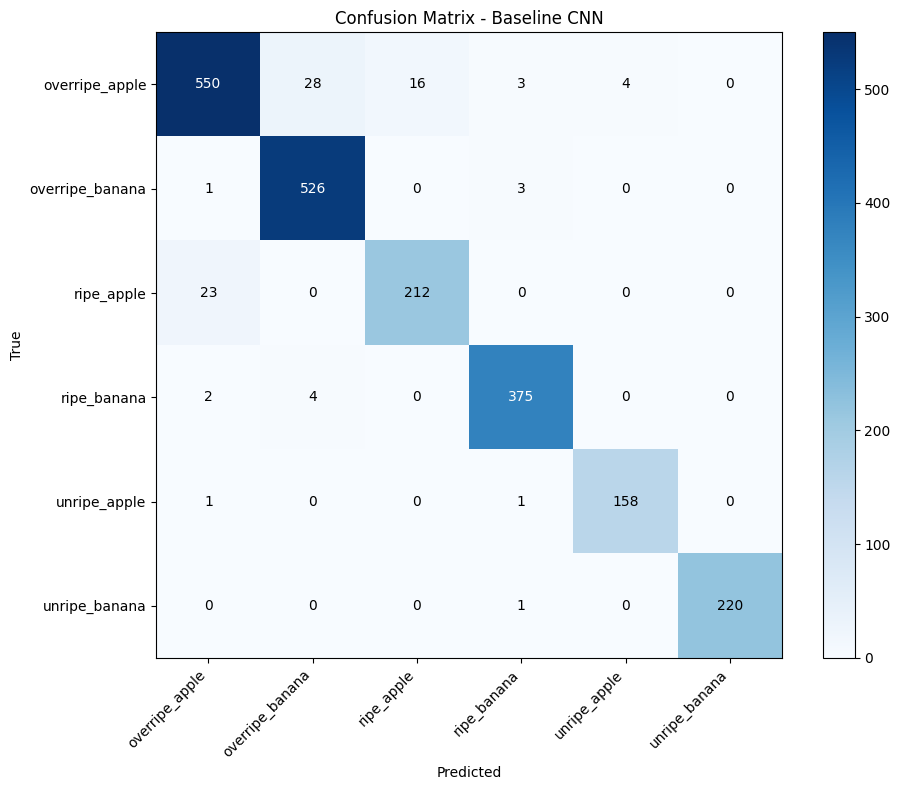


🔍 Evaluating MobileNetV2 Transfer Learning...
   └─ Making predictions...
   └─ Making predictions...

=== MobileNetV2 Transfer Learning RESULTS ===
Test Accuracy : 0.9948
Test Precision: 0.9939
Test Recall   : 0.9947
Test F1-score : 0.9943

Classification Report:

                 precision    recall  f1-score   support

 overripe_apple       0.99      0.99      0.99       601
overripe_banana       1.00      1.00      1.00       530
     ripe_apple       0.98      0.98      0.98       235
    ripe_banana       1.00      1.00      1.00       381
   unripe_apple       0.99      1.00      1.00       160
  unripe_banana       1.00      1.00      1.00       221

       accuracy                           0.99      2128
      macro avg       0.99      0.99      0.99      2128
   weighted avg       0.99      0.99      0.99      2128


=== MobileNetV2 Transfer Learning RESULTS ===
Test Accuracy : 0.9948
Test Precision: 0.9939
Test Recall   : 0.9947
Test F1-score : 0.9943

Classification Repor

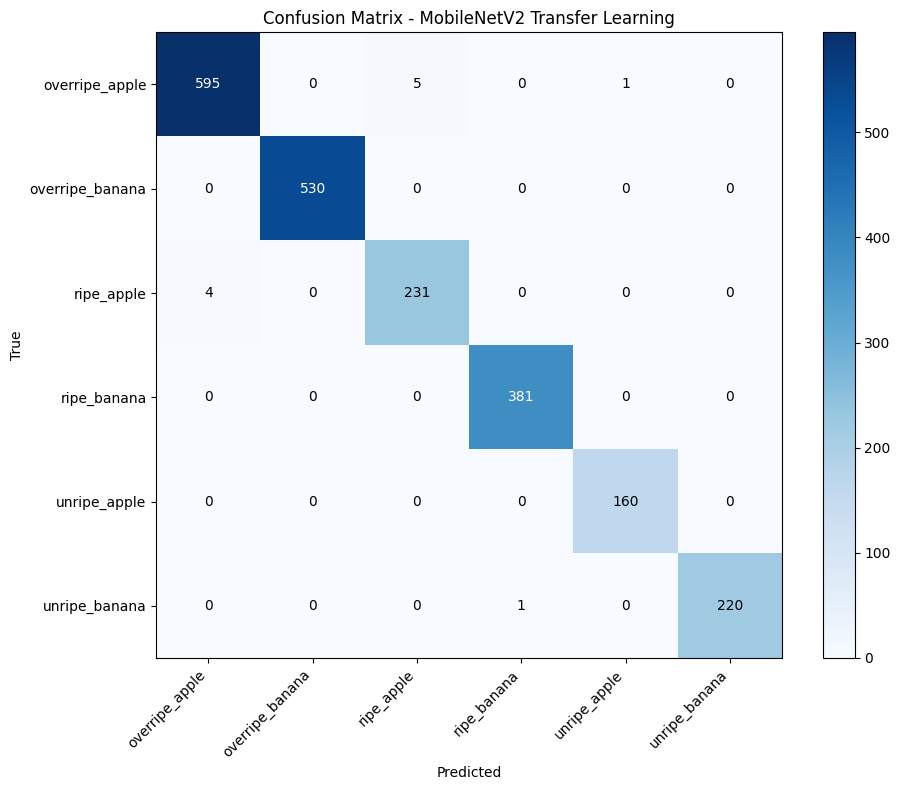

✅ Evaluasi selesai!


In [37]:
# 9️⃣ EVALUASI MODEL DI TEST SET

# Load model terbaik yang disimpan oleh checkpoint
print("🔄 Memuat model terbaik dari checkpoint...")
baseline_cnn_best = tf.keras.models.load_model('model_checkpoints/baseline_cnn_best.keras')
transfer_model_best = tf.keras.models.load_model('model_checkpoints/mobilenetv2_best.keras')
print("✅ Model terbaik berhasil dimuat.")

# Fungsi evaluasi (dari kode Anda)
def evaluate_model(model, test_ds, model_name, class_names_list):
    print(f"\n🔍 Evaluating {model_name}...")
    
    y_true_list = []
    for _, y in test_ds:
        y_true_list.append(np.argmax(y.numpy(), axis=1))
    y_true = np.concatenate(y_true_list, axis=0)
    
    print("   └─ Making predictions...")
    y_pred_prob = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    print(f"\n=== {model_name} RESULTS ===")
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall   : {recall:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    
    print(f"\nClassification Report:\n")
    # PERBAIKAN: Pastikan target_names adalah list
    print(classification_report(y_true, y_pred, target_names=class_names_list))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8)) # Ukuran disesuaikan untuk 6 kelas
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=range(len(class_names_list)), labels=class_names_list, rotation=45, ha='right')
    plt.yticks(ticks=range(len(class_names_list)), labels=class_names_list)
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return acc, precision, recall, f1, y_true, y_pred

print("🚀 Memulai evaluasi model pada test set...")
print("=" * 60)

# Evaluasi kedua model
baseline_metrics = evaluate_model(baseline_cnn_best, test_ds, "Baseline CNN", class_names)
transfer_metrics = evaluate_model(transfer_model_best, test_ds, "MobileNetV2 Transfer Learning", class_names)

print("=" * 60)
print("✅ Evaluasi selesai!")

📊 VISUALISASI TRAINING HISTORY - BASELINE CNN
------------------------------------------------------------


C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2282839346.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dandy\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dandy\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


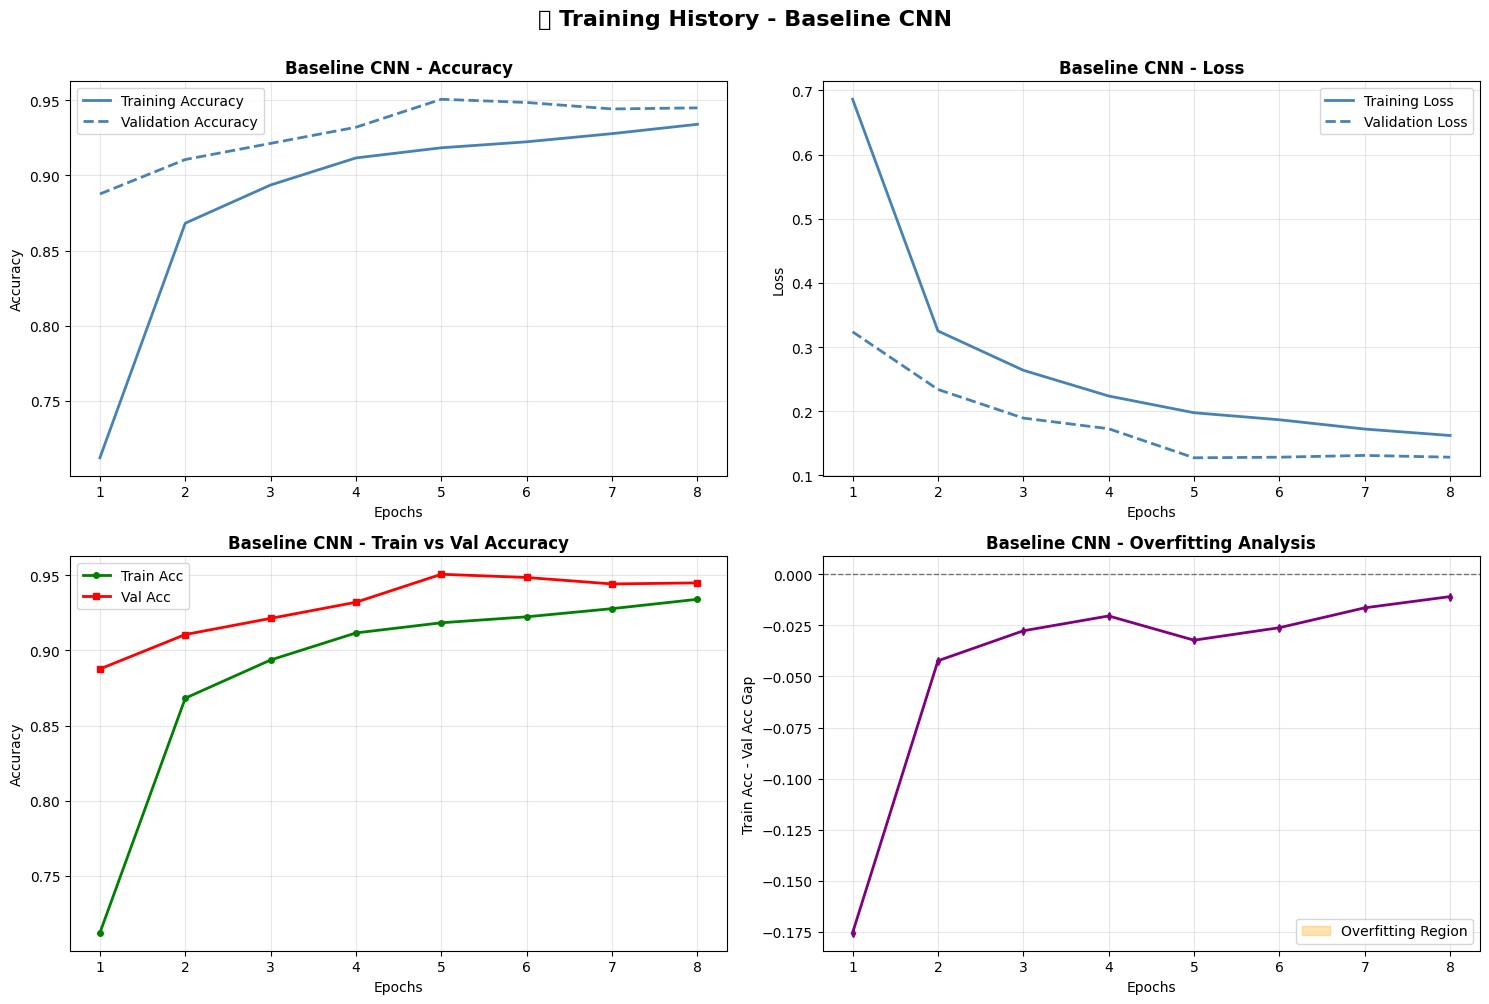

📈 Baseline CNN - Training Statistics:
   ├─ Total Epochs Trained: 8
   ├─ Final Train Accuracy: 0.9340
   ├─ Final Val Accuracy: 0.9449
   ├─ Best Val Accuracy: 0.9506 (Epoch 5)
   ├─ Final Train Loss: 0.1622
   ├─ Final Val Loss: 0.1284
   ├─ Best Val Loss: 0.1274 (Epoch 5)
   └─ Final Overfitting Gap: -0.0109

✅ Small gap (-0.0109) - Good generalization!


In [38]:
# 🔟.1️⃣ VISUALISASI TRAINING HISTORY - BASELINE CNN

def plot_training_history(history, model_name, color='blue'):
    """
    Visualisasi training history untuk satu model
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Training & Validation Accuracy
    axes[0, 0].plot(epochs_range, history.history['accuracy'], 
                    color=color, linestyle='-', linewidth=2, label='Training Accuracy')
    axes[0, 0].plot(epochs_range, history.history['val_accuracy'], 
                    color=color, linestyle='--', linewidth=2, label='Validation Accuracy')
    axes[0, 0].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Training & Validation Loss
    axes[0, 1].plot(epochs_range, history.history['loss'], 
                    color=color, linestyle='-', linewidth=2, label='Training Loss')
    axes[0, 1].plot(epochs_range, history.history['val_loss'], 
                    color=color, linestyle='--', linewidth=2, label='Validation Loss')
    axes[0, 1].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy Comparison (Train vs Val)
    axes[1, 0].plot(epochs_range, history.history['accuracy'], 
                    color='green', linestyle='-', linewidth=2, marker='o', 
                    markersize=4, label='Train Acc')
    axes[1, 0].plot(epochs_range, history.history['val_accuracy'], 
                    color='red', linestyle='-', linewidth=2, marker='s', 
                    markersize=4, label='Val Acc')
    axes[1, 0].set_title(f'{model_name} - Train vs Val Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Learning Curve Analysis
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    gap = [t - v for t, v in zip(train_acc, val_acc)]
    
    axes[1, 1].plot(epochs_range, gap, color='purple', linewidth=2, marker='d', markersize=4)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 1].fill_between(epochs_range, gap, 0, where=[g > 0 for g in gap], 
                           alpha=0.3, color='orange', label='Overfitting Region')
    axes[1, 1].set_title(f'{model_name} - Overfitting Analysis', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Train Acc - Val Acc Gap')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'📊 Training History - {model_name}', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # Print statistik
    print(f"📈 {model_name} - Training Statistics:")
    print("=" * 60)
    print(f"   ├─ Total Epochs Trained: {len(epochs_range)}")
    print(f"   ├─ Final Train Accuracy: {train_acc[-1]:.4f}")
    print(f"   ├─ Final Val Accuracy: {val_acc[-1]:.4f}")
    print(f"   ├─ Best Val Accuracy: {max(val_acc):.4f} (Epoch {val_acc.index(max(val_acc)) + 1})")
    print(f"   ├─ Final Train Loss: {history.history['loss'][-1]:.4f}")
    print(f"   ├─ Final Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"   ├─ Best Val Loss: {min(history.history['val_loss']):.4f} (Epoch {history.history['val_loss'].index(min(history.history['val_loss'])) + 1})")
    print(f"   └─ Final Overfitting Gap: {gap[-1]:.4f}")
    
    # Analisis overfitting
    if gap[-1] > 0.1:
        print(f"\n⚠️  WARNING: Large gap detected ({gap[-1]:.4f}) - Possible overfitting!")
    elif gap[-1] > 0.05:
        print(f"\n💡 Moderate gap ({gap[-1]:.4f}) - Model is learning well")
    else:
        print(f"\n✅ Small gap ({gap[-1]:.4f}) - Good generalization!")
    print("=" * 60)

print("📊 VISUALISASI TRAINING HISTORY - BASELINE CNN")
print("-" * 60)
plot_training_history(history_baseline, "Baseline CNN", color='steelblue')


📊 VISUALISASI TRAINING HISTORY - MOBILENETV2 TRANSFER LEARNING
------------------------------------------------------------


C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2282839346.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


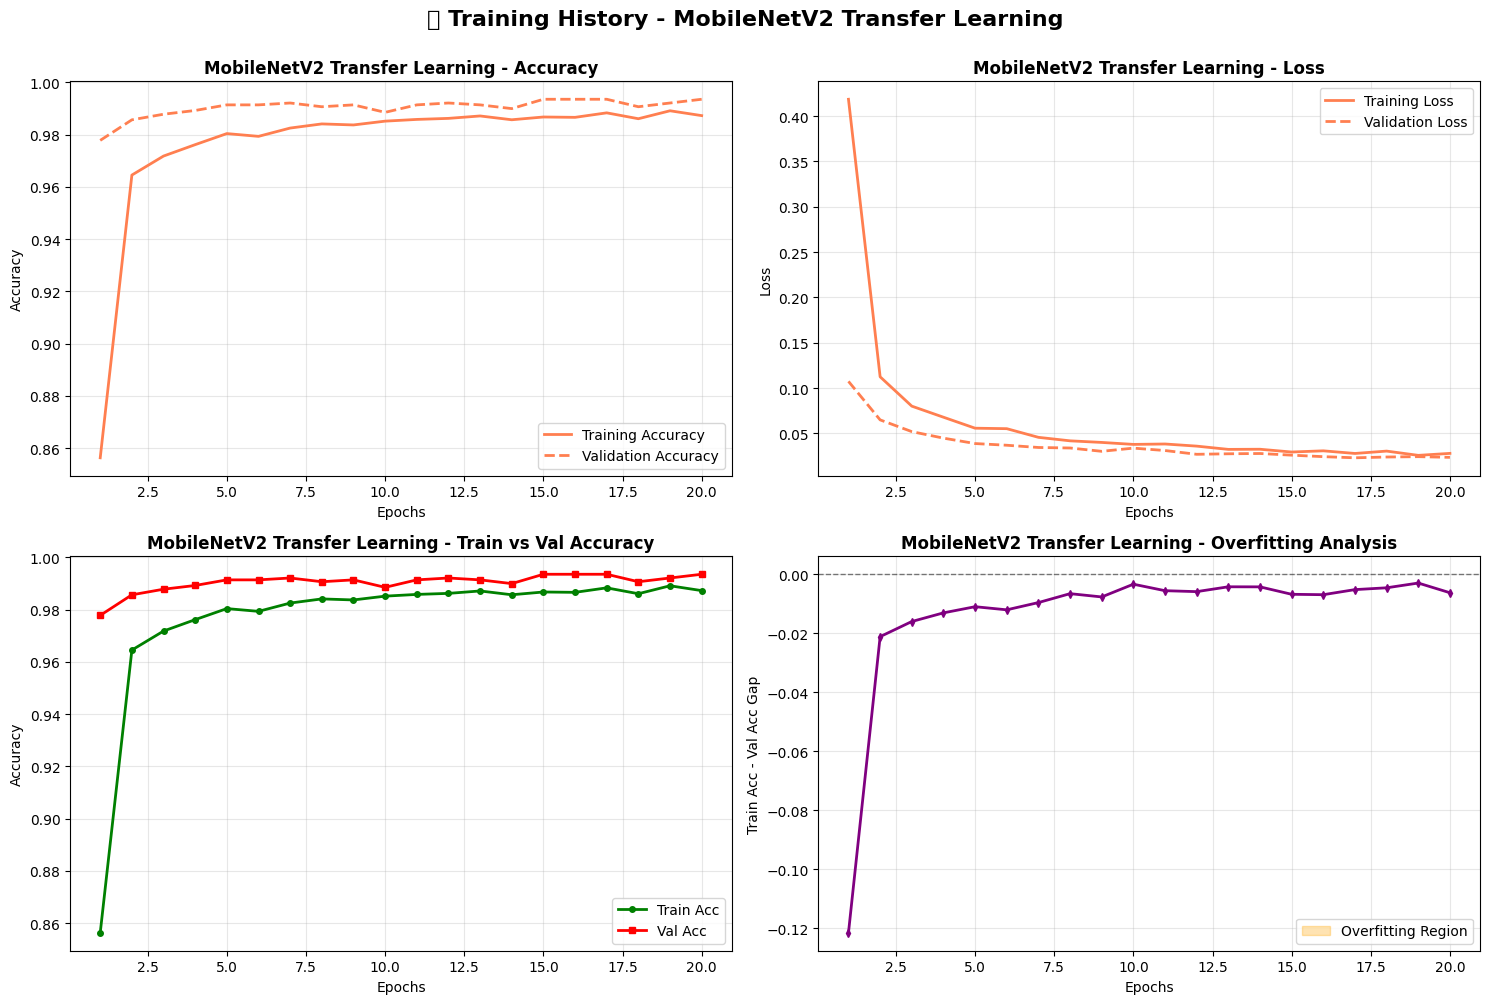

📈 MobileNetV2 Transfer Learning - Training Statistics:
   ├─ Total Epochs Trained: 20
   ├─ Final Train Accuracy: 0.9873
   ├─ Final Val Accuracy: 0.9936
   ├─ Best Val Accuracy: 0.9936 (Epoch 15)
   ├─ Final Train Loss: 0.0281
   ├─ Final Val Loss: 0.0237
   ├─ Best Val Loss: 0.0232 (Epoch 17)
   └─ Final Overfitting Gap: -0.0063

✅ Small gap (-0.0063) - Good generalization!


In [39]:
# 🔟.2️⃣ VISUALISASI TRAINING HISTORY - MOBILENETV2 TRANSFER LEARNING

print("\n📊 VISUALISASI TRAINING HISTORY - MOBILENETV2 TRANSFER LEARNING")
print("-" * 60)
plot_training_history(history_transfer, "MobileNetV2 Transfer Learning", color='coral')


🔍 PERBANDINGAN SIDE-BY-SIDE KEDUA MODEL
--------------------------------------------------------------------------------


C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2144403927.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2144403927.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2144403927.py:60: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dandy\AppData\Local\Temp\ipykernel_19080\2144403927.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dandy\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dandy\AppData\Roaming\Python\Python313\site-packages\IPython\co

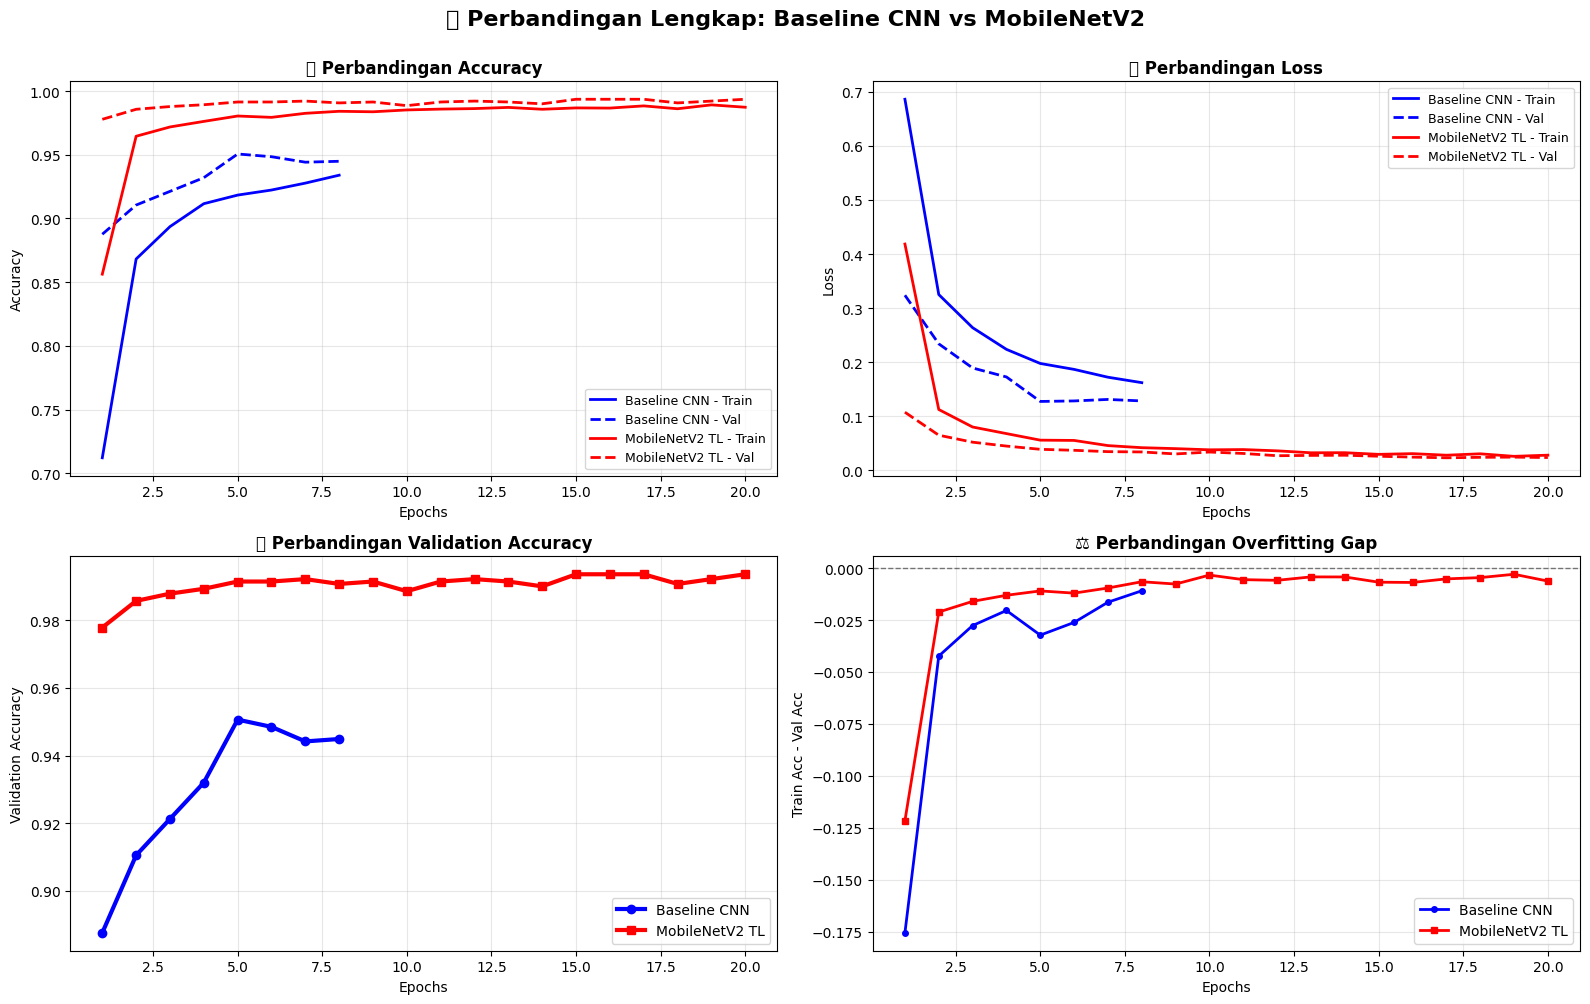


📊 TABEL PERBANDINGAN:
               Metric Baseline CNN MobileNetV2 TL
       Epochs Trained            8             20
    Best Val Accuracy       0.9506         0.9936
   Final Val Accuracy       0.9449         0.9936
 Final Train Accuracy       0.9340         0.9873
        Best Val Loss       0.1274         0.0232
Final Overfitting Gap      -0.0109        -0.0063

🏆 ANALISIS PEMENANG:
   ✅ MobileNetV2 TL MENANG!
   Improvement: +4.29% accuracy


In [40]:
# 🔟.3️⃣ PERBANDINGAN SIDE-BY-SIDE KEDUA MODEL

def compare_models_sidebyside(history1, history2, model1_name, model2_name):
    """
    Perbandingan side-by-side antara dua model
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    epochs1 = range(1, len(history1.history['accuracy']) + 1)
    epochs2 = range(1, len(history2.history['accuracy']) + 1)
    
    # 1. Accuracy Comparison
    axes[0, 0].plot(epochs1, history1.history['accuracy'], 'b-', linewidth=2, label=f'{model1_name} - Train')
    axes[0, 0].plot(epochs1, history1.history['val_accuracy'], 'b--', linewidth=2, label=f'{model1_name} - Val')
    axes[0, 0].plot(epochs2, history2.history['accuracy'], 'r-', linewidth=2, label=f'{model2_name} - Train')
    axes[0, 0].plot(epochs2, history2.history['val_accuracy'], 'r--', linewidth=2, label=f'{model2_name} - Val')
    axes[0, 0].set_title('📊 Perbandingan Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Loss Comparison
    axes[0, 1].plot(epochs1, history1.history['loss'], 'b-', linewidth=2, label=f'{model1_name} - Train')
    axes[0, 1].plot(epochs1, history1.history['val_loss'], 'b--', linewidth=2, label=f'{model1_name} - Val')
    axes[0, 1].plot(epochs2, history2.history['loss'], 'r-', linewidth=2, label=f'{model2_name} - Train')
    axes[0, 1].plot(epochs2, history2.history['val_loss'], 'r--', linewidth=2, label=f'{model2_name} - Val')
    axes[0, 1].set_title('📉 Perbandingan Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Validation Accuracy Only
    axes[1, 0].plot(epochs1, history1.history['val_accuracy'], 'b-', linewidth=3, 
                    marker='o', markersize=6, label=model1_name)
    axes[1, 0].plot(epochs2, history2.history['val_accuracy'], 'r-', linewidth=3, 
                    marker='s', markersize=6, label=model2_name)
    axes[1, 0].set_title('🎯 Perbandingan Validation Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Accuracy')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Overfitting Gap Comparison
    gap1 = [t - v for t, v in zip(history1.history['accuracy'], history1.history['val_accuracy'])]
    gap2 = [t - v for t, v in zip(history2.history['accuracy'], history2.history['val_accuracy'])]
    
    axes[1, 1].plot(epochs1, gap1, 'b-', linewidth=2, marker='o', markersize=4, label=model1_name)
    axes[1, 1].plot(epochs2, gap2, 'r-', linewidth=2, marker='s', markersize=4, label=model2_name)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 1].set_title('⚖️ Perbandingan Overfitting Gap', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Train Acc - Val Acc')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('🔍 Perbandingan Lengkap: Baseline CNN vs MobileNetV2', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print("\n📊 TABEL PERBANDINGAN:")
    print("=" * 80)
    
    comparison_data = {
        'Metric': [
            'Epochs Trained',
            'Best Val Accuracy',
            'Final Val Accuracy',
            'Final Train Accuracy',
            'Best Val Loss',
            'Final Overfitting Gap'
        ],
        model1_name: [
            len(epochs1),
            f"{max(history1.history['val_accuracy']):.4f}",
            f"{history1.history['val_accuracy'][-1]:.4f}",
            f"{history1.history['accuracy'][-1]:.4f}",
            f"{min(history1.history['val_loss']):.4f}",
            f"{gap1[-1]:.4f}"
        ],
        model2_name: [
            len(epochs2),
            f"{max(history2.history['val_accuracy']):.4f}",
            f"{history2.history['val_accuracy'][-1]:.4f}",
            f"{history2.history['accuracy'][-1]:.4f}",
            f"{min(history2.history['val_loss']):.4f}",
            f"{gap2[-1]:.4f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    
    # Winner analysis
    val_acc_1 = max(history1.history['val_accuracy'])
    val_acc_2 = max(history2.history['val_accuracy'])
    
    print("\n🏆 ANALISIS PEMENANG:")
    if val_acc_2 > val_acc_1:
        improvement = (val_acc_2 - val_acc_1) * 100
        print(f"   ✅ {model2_name} MENANG!")
        print(f"   Improvement: +{improvement:.2f}% accuracy")
    elif val_acc_1 > val_acc_2:
        improvement = (val_acc_1 - val_acc_2) * 100
        print(f"   ✅ {model1_name} MENANG!")
        print(f"   Improvement: +{improvement:.2f}% accuracy")
    else:
        print("   🤝 Hasil SAMA!")
    print("=" * 80)

print("\n🔍 PERBANDINGAN SIDE-BY-SIDE KEDUA MODEL")
print("-" * 80)
compare_models_sidebyside(
    history_baseline,
    history_transfer,
    "Baseline CNN",
    "MobileNetV2 TL"
)

In [41]:
# 1️⃣1️⃣ SIMPAN HASIL EVALUASI KE FILE (CSV & JSON)

print("💾 Menyimpan hasil evaluasi ke file...")
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# === 1. Simpan Ringkasan Metrik Utama ===
results_data = {
    'Model': ['Baseline CNN', 'MobileNetV2 Transfer Learning'],
    'Test_Accuracy': [baseline_metrics[0], transfer_metrics[0]],
    'Test_Precision_Macro': [baseline_metrics[1], transfer_metrics[1]],
    'Test_Recall_Macro': [baseline_metrics[2], transfer_metrics[2]],
    'Test_F1_Score_Macro': [baseline_metrics[3], transfer_metrics[3]],
    'Best_Val_Accuracy': [
        max(history_baseline.history['val_accuracy']),
        max(history_transfer.history['val_accuracy'])
    ],
    'Epochs_Trained': [
        len(history_baseline.history['loss']), 
        len(history_transfer.history['loss'])
    ]
}
results_df = pd.DataFrame(results_data)
results_df.to_csv(f'results_{timestamp}.csv', index=False)
results_df.to_csv('results.csv', index=False)
print("   📄 results.csv (Ringkasan metrik) ...OK")


# === 2. Simpan Classification Reports (JSON) ===
y_true_base, y_pred_base = baseline_metrics[4], baseline_metrics[5]
y_true_trans, y_pred_trans = transfer_metrics[4], transfer_metrics[5]

baseline_report = classification_report(y_true_base, y_pred_base, target_names=class_names, output_dict=True)
transfer_report = classification_report(y_true_trans, y_pred_trans, target_names=class_names, output_dict=True)

with open(f'classification_report_baseline_{timestamp}.json', 'w') as f:
    json.dump(baseline_report, f, indent=2)
with open('classification_report_baseline.json', 'w') as f:
    json.dump(baseline_report, f, indent=2)

with open(f'classification_report_transfer_{timestamp}.json', 'w') as f:
    json.dump(transfer_report, f, indent=2)
with open('classification_report_transfer.json', 'w') as f:
    json.dump(transfer_report, f, indent=2)

print("   📄 classification_report_*.json (Detail report) ...OK")

# === 3. Simpan Confusion Matrices (CSV) ===
cm_baseline = confusion_matrix(y_true_base, y_pred_base)
cm_transfer = confusion_matrix(y_true_trans, y_pred_trans)

cm_baseline_df = pd.DataFrame(cm_baseline, columns=class_names, index=class_names)
cm_transfer_df = pd.DataFrame(cm_transfer, columns=class_names, index=class_names)

cm_baseline_df.to_csv(f'confusion_matrix_baseline_{timestamp}.csv')
cm_transfer_df.to_csv(f'confusion_matrix_transfer_{timestamp}.csv')
cm_baseline_df.to_csv('confusion_matrix_baseline.csv')
cm_transfer_df.to_csv('confusion_matrix_transfer.csv')
print("   📄 confusion_matrix_*.csv (Confusion matrix) ...OK")


print("\n✅ Semua hasil evaluasi berhasil disimpan!")

💾 Menyimpan hasil evaluasi ke file...
   📄 results.csv (Ringkasan metrik) ...OK
   📄 classification_report_*.json (Detail report) ...OK
   📄 confusion_matrix_*.csv (Confusion matrix) ...OK

✅ Semua hasil evaluasi berhasil disimpan!


In [42]:
# 1️⃣2️⃣ RINGKASAN FINAL EKSPERIMEN

print("🎉 EKSPERIMEN SELESAI!")
print("=" * 80)
print("\n🏆 RINGKASAN PERFORMA PADA TEST SET:\n")

print(results_df.round(4).to_markdown(index=False))

print("\n" + "=" * 80)
improvement = transfer_metrics[0] - baseline_metrics[0]
if improvement > 0:
    print(f"✅ Transfer Learning (MobileNetV2) menang!")
    print(f"   Improvement Akurasi: {improvement:+.4f} (+{improvement*100:+.2f}%)")
elif improvement < 0:
    print(f"🤔 Baseline CNN menang!")
    print(f"   Improvement Akurasi: {improvement:+.4f} ({improvement*100:+.2f}%)")
else:
    print("🤝 Hasil sama!")

print("=" * 80)
print(f"📁 Model terbaik disimpan di folder 'model_checkpoints/'")
print(f"📄 Hasil metrik lengkap disimpan di 'results.csv' & 'per_class_results.csv'")

🎉 EKSPERIMEN SELESAI!

🏆 RINGKASAN PERFORMA PADA TEST SET:

| Model                         |   Test_Accuracy |   Test_Precision_Macro |   Test_Recall_Macro |   Test_F1_Score_Macro |   Best_Val_Accuracy |   Epochs_Trained |
|:------------------------------|----------------:|-----------------------:|--------------------:|----------------------:|--------------------:|-----------------:|
| Baseline CNN                  |          0.9591 |                 0.9634 |              0.9628 |                0.9629 |              0.9506 |                8 |
| MobileNetV2 Transfer Learning |          0.9948 |                 0.9939 |              0.9947 |                0.9943 |              0.9936 |               20 |

✅ Transfer Learning (MobileNetV2) menang!
   Improvement Akurasi: +0.0357 (++3.57%)
📁 Model terbaik disimpan di folder 'model_checkpoints/'
📄 Hasil metrik lengkap disimpan di 'results.csv' & 'per_class_results.csv'


In [43]:
# 1️⃣3️⃣ PREDIKSI GAMBAR TUNGGAL

import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# Muat model terbaik (MobileNetV2)
try:
    best_model = tf.keras.models.load_model('model_checkpoints/mobilenetv2_best.keras')
    print(f"🧠 Model 'mobilenetv2_best.keras' berhasil dimuat untuk prediksi.")
except Exception as e:
    print(f"⚠️ Gagal memuat model: {e}. Pastikan sel training sudah dijalankan.")
    best_model = None

# Widget UI
upload = widgets.FileUpload(
    accept='.jpg,.jpeg,.png,.bmp,.gif,.tiff',
    multiple=False,
    description='Upload Gambar'
)
predict_button = widgets.Button(
    description='Prediksi',
    button_style='primary',
    tooltip='Klik untuk memprediksi gambar yang diupload'
)
output = widgets.Output()

# Fungsi untuk mengambil file dari widget
def get_uploaded_file(upload_widget):
    val = upload_widget.value
    if isinstance(val, (tuple, list)) and len(val) > 0: # ipywidgets 8.x
        return val[0].name, val[0].content
    if isinstance(val, dict) and len(val) > 0: # ipywidgets 7.x
        file_info = list(val.values())[0]
        return file_info.get('metadata', {}).get('name'), file_info.get('content')
    return None, None

# Fungsi event handler
def on_predict_clicked(b):
    with output:
        clear_output(wait=True)
        if best_model is None:
            print("Model tidak dapat digunakan. Harap jalankan sel training.")
            return
            
        name, content = get_uploaded_file(upload)
        if not content:
            print("Silakan upload 1 gambar terlebih dahulu.")
            return

        try:
            # Load dan preprocess gambar
            img = Image.open(io.BytesIO(content)).convert('RGB').resize(IMG_SIZE)
            img_array = tf.expand_dims(np.array(img), 0) # Model akan handle rescaling
            
            # Prediksi
            preds = best_model.predict(img_array, verbose=0)
            pred_idx = int(np.argmax(preds))
            pred_class = class_names[pred_idx]
            confidence = float(np.max(preds) * 100)

            # Tampilkan hasil
            print(f"Gambar: {name}")
            print(f"Prediksi: {pred_class} ({confidence:.2f}%)\n")

            plt.figure(figsize=(6, 5))
            plt.imshow(img)
            plt.title(f"Prediksi: {pred_class} ({confidence:.2f}%)")
            plt.axis('off')
            plt.show()

            print("\nProbabilitas (Confidence Score):")
            for i, cname in enumerate(class_names):
                prob = float(preds[0][i] * 100)
                print(f"  {cname:20s}: {prob:.2f}%")
        
        except Exception as e:
            print(f"Error memproses gambar: {e}")

# Tampilkan widget
predict_button.on_click(on_predict_clicked)
display(widgets.VBox([
    widgets.HTML('<b>Upload gambar buah (Apple/Banana) untuk diprediksi:</b>'),
    upload,
    predict_button,
    output
]))

🧠 Model 'mobilenetv2_best.keras' berhasil dimuat untuk prediksi.
